In [1]:
from dataset import ImagingDataset

# get dataset
subj_list = ['sub-02']  # we are just testing a single subject
ds = ImagingDataset(subj_list,
                    '/home/lukeh/hpcworking/shared/projects/LST7T/data/')

# basic parameters
task = 'LST'
smooth = 4.0

In [2]:
from nilearn.glm.first_level import FirstLevelModel

# create a GLM object with more or less default params
# get image specs
t_r, slice_time_ref = ds.get_tr_and_slice_time()

# create GLM object with almost entirely default parameters
model = FirstLevelModel(t_r=t_r,
                        slice_time_ref=slice_time_ref,
                        hrf_model='spm',
                        smoothing_fwhm=smooth,
                        standardize=True,
                        subject_label=ds.raw_subject_list(),
                        verbose=1)

/home/lukeh/miniconda3/envs/LSTANN/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/home/lukeh/projects/LST/code/dataset.py:49: UserWarning: SliceTimingRef not found, using 0.5
  warn('SliceTimingRef not found, using 0.5')


In [3]:
# get the preprocessed images, task events and confounds
from nilearn.interfaces.bids import get_bids_files

# get preprocessed images
img_files = get_bids_files(ds.deriv_path, modality_folder='func',
                            file_tag='bold', file_type='nii.gz',
                            filters=[('task', task),
                            ('space','MNI152NLin2009cAsym')],
                            sub_label=ds.raw_subject_list()[0])
n_runs = len(img_files)

In [6]:
from task_event_models import motor_model

# get task events
event_files = get_bids_files(ds.bids_path, modality_folder='func',
                        file_tag='events', file_type='tsv',
                        sub_label=ds.raw_subject_list()[0])
assert len(event_files) == n_runs, 'Number of images and .tsv events do not match'

events = event_files.copy()

Computing run 1 out of 3 runs (go take a coffee, a big one)
/home/lukeh/miniconda3/envs/LSTANN/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `motor_duration` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/home/lukeh/miniconda3/envs/LSTANN/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `motor_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/home/lukeh/miniconda3/envs/LSTANN/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `confidence_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/home/lukeh/miniconda3/envs/LSTANN/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `confidence_duration` in events data will be ignore

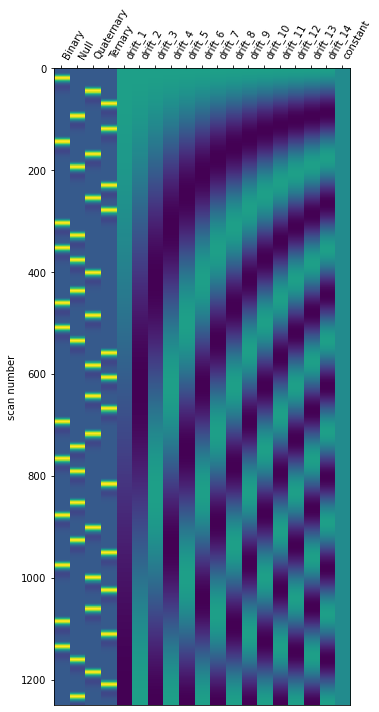

In [7]:
from nilearn.plotting import plot_design_matrix
import matplotlib.pyplot as plt
# fit the model.
model.fit(run_imgs=img_files,
          events=events)

# plot example matrix
plot_design_matrix(model.design_matrices_[0])
plt.show()

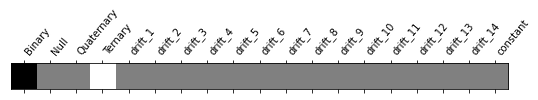

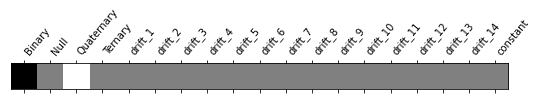

In [8]:
from nilearn import plotting
from scipy.stats import norm
from nilearn.plotting import plot_contrast_matrix
from task_event_models import motor_contrasts


import numpy as np
# create a condition dict
empty_condition = np.zeros((model.design_matrices_[0].shape[1]))
ter_minus_bin = empty_condition.copy()
ter_minus_bin[3] = 1
ter_minus_bin[0] = -1

qua_minus_bin = empty_condition.copy()
qua_minus_bin[2] = 1
qua_minus_bin[0] = -1

contrasts = {'ternary': ter_minus_bin,
                'quaternary': qua_minus_bin}

plot_contrast_matrix(contrasts['ternary'], design_matrix=model.design_matrices_[0])
plt.show()
plot_contrast_matrix(contrasts['quaternary'], design_matrix=model.design_matrices_[0])
plt.show()

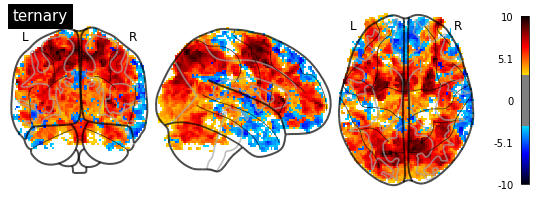

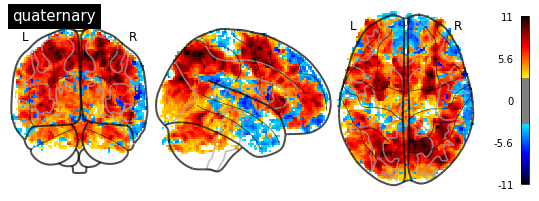

In [10]:

z_map = model.compute_contrast(contrasts['ternary'])
plotting.plot_glass_brain(z_map, colorbar=True, threshold=norm.isf(0.001),
                          title='ternary',
                          plot_abs=False, display_mode='ortho')
plt.show()

z_map = model.compute_contrast(contrasts['quaternary'])
plotting.plot_glass_brain(z_map, colorbar=True, threshold=norm.isf(0.001),
                          title='quaternary',
                          plot_abs=False, display_mode='ortho')
plt.show()